<a href="https://colab.research.google.com/github/SawiniJana/Python/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch
import torch.nn.functional as F


In [76]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(
    root = "./data",
    train = True,
    download = True,
    transform = transform,
    target_transform = None
)

test_data = datasets.MNIST(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

In [77]:
img, label = train_data[90]
print(label)
print(len(train_data))

6
60000


In [78]:
print(train_data.data.shape)
print(train_data.targets)

torch.Size([60000, 28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])


In [79]:
from torch.utils.data import DataLoader

In [80]:
subset_train = torch.utils.data.Subset(train_data, range(1000))
subset_test = torch.utils.data.Subset(test_data, range(1000))
train_loader = DataLoader(subset_train,
                          batch_size = 128,
                          shuffle = True
                          )
test_loader = DataLoader(subset_test,
                          batch_size = 128,
                          shuffle = False
                          )

In [81]:
for data, _ in train_loader:
    print(data.shape)
    break

torch.Size([128, 1, 28, 28])


In [82]:
train_data_1, train_label_1 = next(iter(train_loader))
print(train_data_1.shape)
print(train_label_1)

torch.Size([128, 1, 28, 28])
tensor([1, 4, 6, 9, 3, 8, 7, 3, 1, 9, 1, 5, 1, 9, 4, 1, 7, 6, 4, 2, 7, 6, 3, 7,
        2, 6, 3, 5, 1, 6, 2, 7, 1, 6, 3, 5, 8, 5, 7, 6, 7, 3, 4, 4, 7, 2, 8, 3,
        5, 5, 6, 4, 7, 3, 6, 4, 0, 6, 3, 1, 6, 0, 1, 5, 7, 2, 4, 2, 1, 1, 5, 7,
        4, 9, 7, 0, 4, 8, 1, 5, 8, 0, 6, 4, 5, 9, 1, 9, 5, 8, 1, 8, 2, 2, 0, 3,
        6, 0, 0, 3, 2, 1, 4, 7, 6, 7, 9, 0, 0, 1, 2, 1, 9, 2, 1, 0, 1, 3, 6, 6,
        6, 7, 8, 4, 9, 2, 4, 9])


In [83]:
flatten_model  = nn.Flatten()
x = train_data_1[0]
output = flatten_model(x)
output.shape

torch.Size([1, 784])

In [84]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
class Generator(nn.Module):
    def __init__(self, latent_dim=64, device=None):
        super().__init__()

        self.channels = 1
        self.img_size = (28,28)
        self.latent_dim = latent_dim
        activation = nn.LeakyReLU(0.2)
        self.device = device if device is not None else torch.device("cpu")

        layers_dim = [self.latent_dim, 128, 256, 512, self.img_size[0]*self.img_size[1]*self.channels]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layers_dim[i], layers_dim[i + 1]),
                nn.LayerNorm(layers_dim[i + 1]) if i != len(layers_dim) - 2 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Tanh()
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        out = x.reshape(-1, self.latent_dim)
        for layer in self.layers:
            out = layer(out)
        out = out.reshape(batch_size, self.channels, self.img_size[0], self.img_size[1])
        return out




In [86]:
class Discriminator(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.channels = 1
        self.img_size = (28,28)
        activation  = nn.LeakyReLU(0.2)
        layers_dim = [self.img_size[0]*self.img_size[1]*self.channels, 512, 256, 128, 1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layers_dim[i], layers_dim[i + 1]),
                nn.LayerNorm(layers_dim[i + 1]) if i != len(layers_dim) - 2 else nn.Identity(),
                nn.Dropout(0.3) if i < len(layers_dim) - 2 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])
        self.device = device if device is not None else torch.device("cpu")

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        out = x.reshape(-1, self.img_size[0]*self.img_size[1]*self.channels)
        for layer in self.layers:
            out = layer(out)

        out = out.reshape(batch_size, 1)
        return out




In [87]:
from torch.optim import Adam
generator = Generator(device=device).to(device)
discriminator = Discriminator(device=device).to(device)

optim_g = Adam(generator.parameters(), lr=2E-4, betas=(0.5, 0.999))
optim_d= Adam(discriminator.parameters(), lr=1E-4, betas=(0.5, 0.999))

criterion = torch.nn.BCEWithLogitsLoss()

In [88]:
from tqdm import tqdm
def train(generator, discriminator, train_loader):
    generator.train()
    discriminator.train()

    gen_loss = disc_loss = 0
    step = 0
    for data, _ in train_loader:
        data = data.to(device)
        batch_size = data.shape[0]
        step += 1

        #optimizing discriminator
        #create some fake data using normal distribution
        optim_d.zero_grad()
        fake_im_noise = torch.randn((batch_size, 64), device = device)
        #the fake data will pass through generator to create fake image
        fake_ims = generator(fake_im_noise) #batch,N,H,W
        fake_labels = torch.zeros((batch_size, 1), device=device)*0.1
        true_labels = torch.ones((batch_size, 1), device=device)*0.95

        #I think instead of calling twice we could stack and call
        data += 0.1 * torch.randn_like(data)
        disc_real_pred = discriminator(data)
        disc_fake_pred = discriminator(fake_ims)

        if (torch.sigmoid(disc_real_pred).mean() > 0.9) and (torch.sigmoid(disc_fake_pred).mean() > 0.4):
                print("Skipping discriminator update - too strong")
                continue
        disc_real_loss = criterion(disc_real_pred, true_labels)
        disc_fake_loss = criterion(disc_fake_pred, fake_labels)

        disc_loss = (disc_real_loss + disc_fake_loss)/2
        disc_loss.backward()
        optim_d.step()

        #Optimizing generator
        for _ in range(1):
            optim_g.zero_grad()
            fake_im_noise = torch.randn((batch_size, 64), device=device)
            fake_ims = generator(fake_im_noise)
            disc_fake_pred = discriminator(fake_ims)
            #generator wants fake images to be like real ones
            gen_fake_loss = criterion(disc_fake_pred, true_labels)
            gen_fake_loss.backward()

            if torch.sigmoid(disc_fake_pred).mean() < 0.2:
                for _ in range(2):
                    optim_g.zero_grad()
                    fake_ims = generator(torch.randn(batch_size, 64, device=device))
                    gen_fake_loss = criterion(discriminator(fake_ims), true_labels)
                    gen_fake_loss.backward()
                    optim_g.step()
            else:
                optim_g.step()

        gen_loss += gen_fake_loss.item()
        disc_loss += disc_loss.item()

    gen_loss /= len(train_loader)
    disc_loss /= len(train_loader)

    return gen_loss, disc_loss



In [89]:
import matplotlib.pyplot as plt

def visualise(gen, disc, test_loader):
    fig,ax = plt.subplots(figsize=(2,2),dpi=150)
    gen.eval()
    disc.eval()
    im,_ = next(iter(test_loader))
    im = im.to(device)
    batch_size = 1
    with torch.no_grad():
        xs = torch.randn((batch_size, 64), device=device)
        points = generator(xs)[0]
        image = points.squeeze().detach().cpu().numpy()

        ax.imshow(image, cmap="gray")
        ax.axis("off")

        disc = discriminator(points.unsqueeze(0))
        pred = F.sigmoid(disc).item()

        real_pred = torch.sigmoid(discriminator(im)).mean().item()

        print(f"Discriminator on real: {real_pred:.3f}, on fake: {pred:.3f}")

    if pred > 0.5:
        ax.set_title(f"Real!",fontsize=10)
    else:
        ax.set_title(f"Generated!",fontsize=10)

    plt.show()



In [90]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
generator.apply(weights_init)

Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=784, bias=True)
      (1): Identity()
      (2): Tanh()
    )
  )
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Discriminator on real: 0.840, on fake: 0.810


/tmp/ipython-input-91-1688779377.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_loss.append(np.array(torch.tensor(rel2).cpu().numpy()))


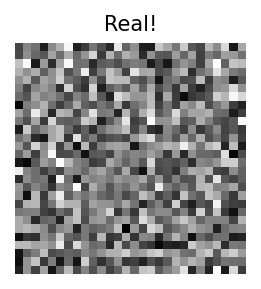

  0%|          | 1/1000 [00:00<06:31,  2.55it/s]

Epoch: 0| Generator Loss: 0.5521466843783855| Discriminator Loss: 0.215799942612648


 10%|█         | 100/1000 [00:31<05:11,  2.89it/s]

Discriminator on real: 0.481, on fake: 0.239


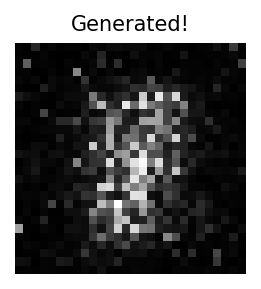

 10%|█         | 101/1000 [00:31<05:09,  2.90it/s]

Epoch: 100| Generator Loss: 1.3800332844257355| Discriminator Loss: 0.1537798047065735


 20%|██        | 200/1000 [01:02<03:54,  3.42it/s]

Discriminator on real: 0.791, on fake: 0.374


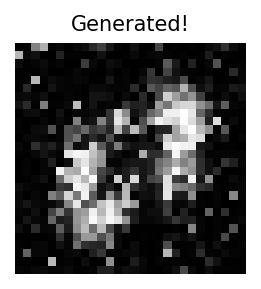

 20%|██        | 201/1000 [01:02<04:12,  3.17it/s]

Epoch: 200| Generator Loss: 1.2511108666658401| Discriminator Loss: 0.1306387186050415


 30%|███       | 300/1000 [01:34<03:28,  3.36it/s]

Discriminator on real: 0.717, on fake: 0.218


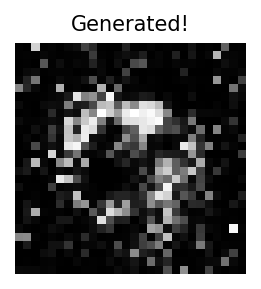

 30%|███       | 301/1000 [01:34<03:38,  3.20it/s]

Epoch: 300| Generator Loss: 1.4993609637022018| Discriminator Loss: 0.11872133612632751


 40%|████      | 400/1000 [02:06<03:39,  2.73it/s]

Discriminator on real: 0.802, on fake: 0.477


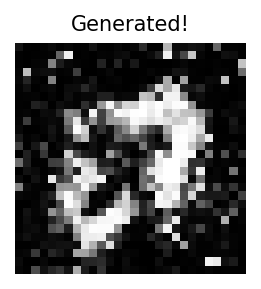

 40%|████      | 401/1000 [02:07<04:16,  2.34it/s]

Epoch: 400| Generator Loss: 1.305906891822815| Discriminator Loss: 0.13352647423744202


 50%|█████     | 500/1000 [02:38<02:36,  3.20it/s]

Discriminator on real: 0.753, on fake: 0.521


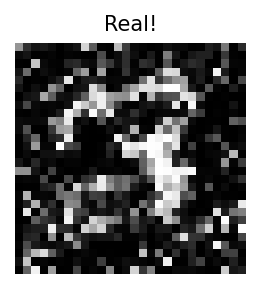

 50%|█████     | 501/1000 [02:39<02:44,  3.02it/s]

Epoch: 500| Generator Loss: 1.3183040171861649| Discriminator Loss: 0.12404108047485352


 60%|██████    | 600/1000 [03:10<01:58,  3.38it/s]

Discriminator on real: 0.748, on fake: 0.219


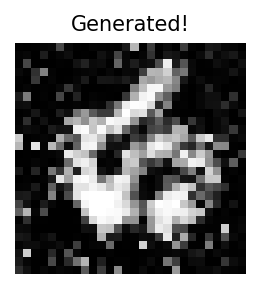

 60%|██████    | 601/1000 [03:10<02:07,  3.14it/s]

Epoch: 600| Generator Loss: 1.3016903400421143| Discriminator Loss: 0.1441260278224945


 70%|███████   | 700/1000 [03:40<01:27,  3.42it/s]

Discriminator on real: 0.561, on fake: 0.493


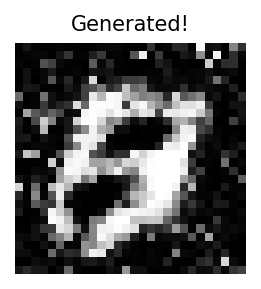

 70%|███████   | 701/1000 [03:41<01:34,  3.16it/s]

Epoch: 700| Generator Loss: 1.2830482870340347| Discriminator Loss: 0.1529974341392517


 80%|████████  | 800/1000 [04:11<00:57,  3.45it/s]

Discriminator on real: 0.774, on fake: 0.873


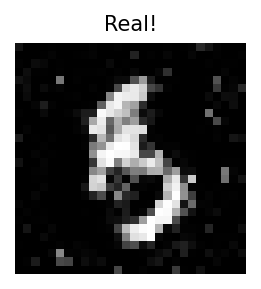

 80%|████████  | 801/1000 [04:12<01:01,  3.23it/s]

Epoch: 800| Generator Loss: 1.2396515980362892| Discriminator Loss: 0.15550033748149872


 90%|█████████ | 900/1000 [04:41<00:28,  3.50it/s]

Discriminator on real: 0.514, on fake: 0.214


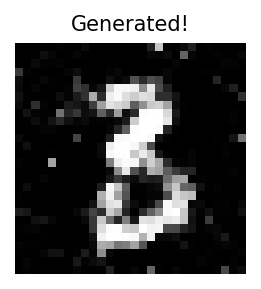

 90%|█████████ | 901/1000 [04:42<00:30,  3.25it/s]

Epoch: 900| Generator Loss: 1.24435805529356| Discriminator Loss: 0.1427648514509201


100%|█████████▉| 999/1000 [05:12<00:00,  3.46it/s]

Discriminator on real: 0.686, on fake: 0.711


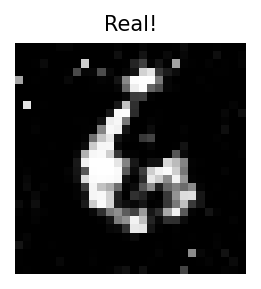

100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]

Epoch: 999| Generator Loss: 1.2954506650567055| Discriminator Loss: 0.13411599397659302


In [91]:
#store the loss (how bad generator is)
#store the loss(how bad discriminator is at recognising)
g_loss = []
d_loss = []
ep = []
num_epoch = 1000
import numpy as np
from tqdm import trange
for epoch in trange(num_epoch):
    rel1, rel2 = train(generator, discriminator, train_loader)
    g_loss.append(np.array(torch.tensor(rel1).cpu().numpy()))
    d_loss.append(np.array(torch.tensor(rel2).cpu().numpy()))
    ep.append(epoch)

    if epoch%100 == 0 or epoch == num_epoch-1:
        visualise(generator, discriminator, test_loader )
        print(f"Epoch: {epoch}| Generator Loss: {rel1}| Discriminator Loss: {rel2}")
    torch.save(generator.state_dict(), 'generator_ckpt.pth')
    torch.save(discriminator.state_dict(), 'discriminator_ckpt.pth')


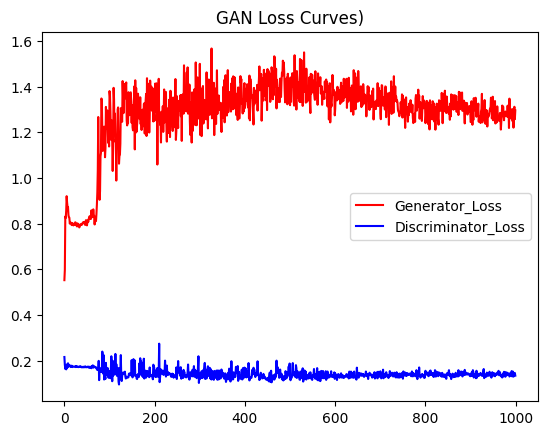

In [92]:
import matplotlib.pyplot as plt
plt.plot(ep, g_loss, color = "red", label = "Generator_Loss")
plt.plot(ep, d_loss, color = "blue", label="Discriminator_Loss")
plt.legend()
plt.title("GAN Loss Curves)")
plt.show()